In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import sqlite3

In [10]:
files = [
    r'D:\OneDrive\Desktop\YouTube Trending Videos Project\USvideos.csv',
    r'D:\OneDrive\Desktop\YouTube Trending Videos Project\INvideos.csv',
    r'D:\OneDrive\Desktop\YouTube Trending Videos Project\GBvideos.csv'
]

dataframes = []

for file in files:
    df = pd.read_csv(file, quotechar='"', encoding='utf-8', on_bad_lines='skip')
    df['region'] = file.split('\\')[-1][:2]  # safer: extracts 'US', 'IN', 'GB'
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)


In [ ]:
df_all = pd.concat(dataframes, ignore_index=True)


In [13]:
# Convert to datetime
df_all['trending_date'] = pd.to_datetime(df_all['trending_date'], format='%y.%d.%m')
df_all['publish_time'] = pd.to_datetime(df_all['publish_time'])

# Drop duplicates
df_all.drop_duplicates(inplace=True)

# Clean tags column
df_all['tags'] = df_all['tags'].str.replace('[\"|#]', '', regex=True)


In [14]:
def get_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

df_all['title_sentiment'] = df_all['title'].apply(get_sentiment)

def sentiment_label(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df_all['sentiment_label'] = df_all['title_sentiment'].apply(sentiment_label)


In [15]:
conn = sqlite3.connect("youtube_trending.db")
df_all.to_sql("trending_videos", conn, if_exists="replace", index=False)


76383

In [17]:
conn = sqlite3.connect('youtube.db')
combined_df.to_sql('trending_videos', conn, if_exists='replace', index=False)
print(combined_df.columns)


Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'region', 'comment_total',
       'date'],
      dtype='object')


In [18]:
query = """
SELECT category_id, ROUND(AVG(views), 0) AS avg_views
FROM trending_videos
GROUP BY category_id
ORDER BY avg_views DESC
"""

df_category_views = pd.read_sql(query, conn)
print(df_category_views)


    category_id  avg_views
0            10  3665985.0
1            30  3065001.0
2             1  2240974.0
3            20  1657624.0
4            17  1602366.0
5            24  1273410.0
6             2  1258440.0
7            23  1131246.0
8            29  1075748.0
9            28  1001549.0
10           22   883748.0
11           26   779089.0
12           19   774817.0
13           43   686437.0
14           15   680856.0
15           27   423019.0
16           25   418461.0


In [19]:
duration_df = df_all.groupby('video_id')['trending_date'].nunique().reset_index()
duration_df.columns = ['video_id', 'days_trending']


C:\Users\adity\AppData\Local\Temp\ipykernel_18056\1484015584.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_category_views, x='avg_views', y='category_id', palette='viridis')


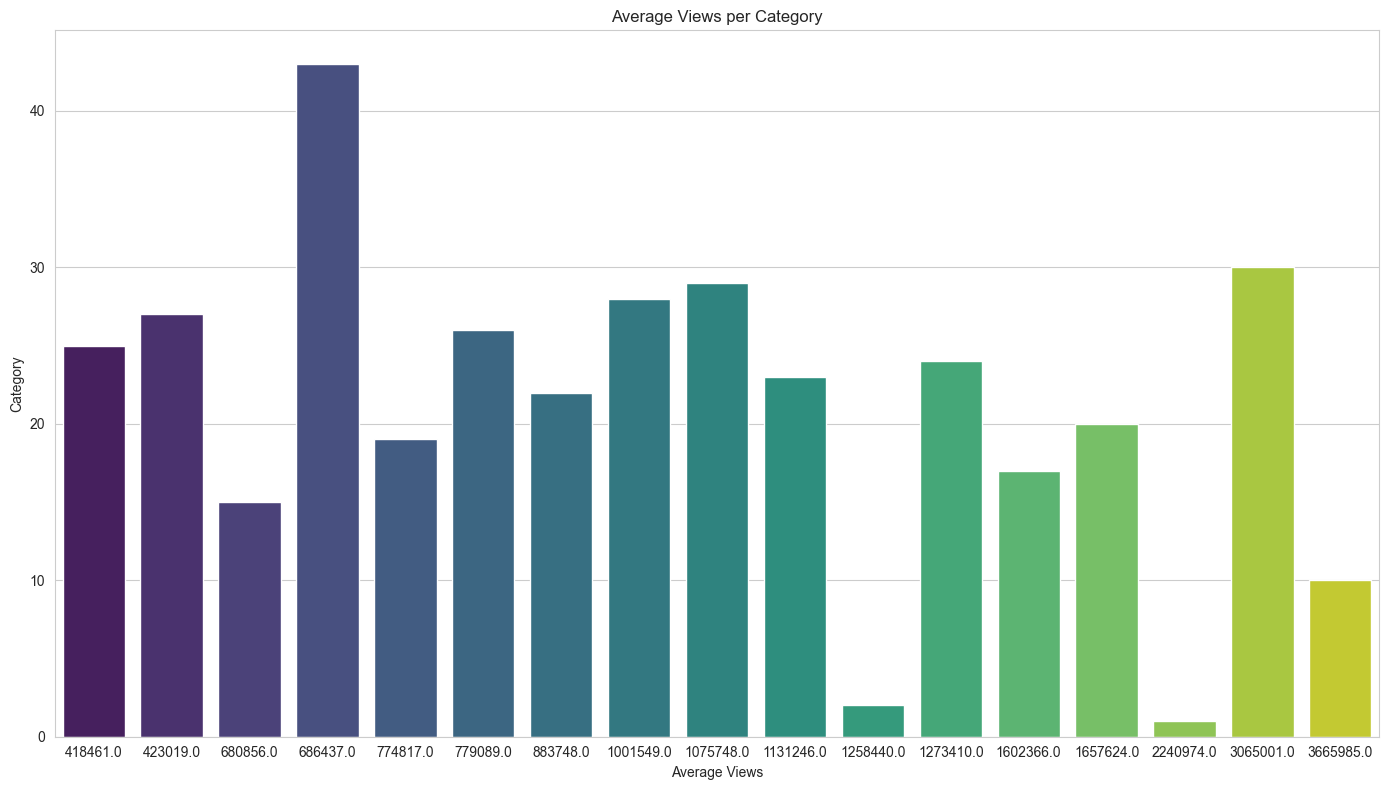

In [32]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))
sns.barplot(data=df_category_views, x='avg_views', y='category_id', palette='viridis')
plt.title("Average Views per Category")
plt.xlabel("Average Views")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

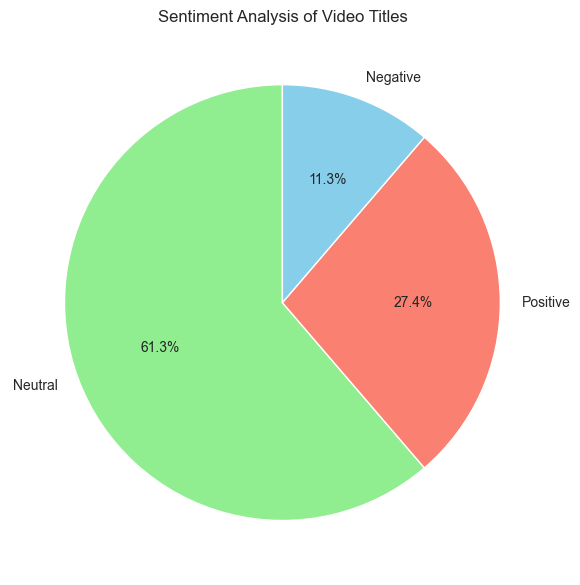

In [37]:
sns.set_style("whitegrid")
plt.figure(figsize=(6, 8))
sentiment_counts = df_all['sentiment_label'].value_counts()
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightgreen','salmon','skyblue'])
plt.title("Sentiment Analysis of Video Titles")
plt.ylabel('')
plt.tight_layout()
plt.show()


C:\Users\adity\AppData\Local\Temp\ipykernel_18056\1053725057.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=category_duration, x='days_trending', y='category_id', palette='coolwarm')


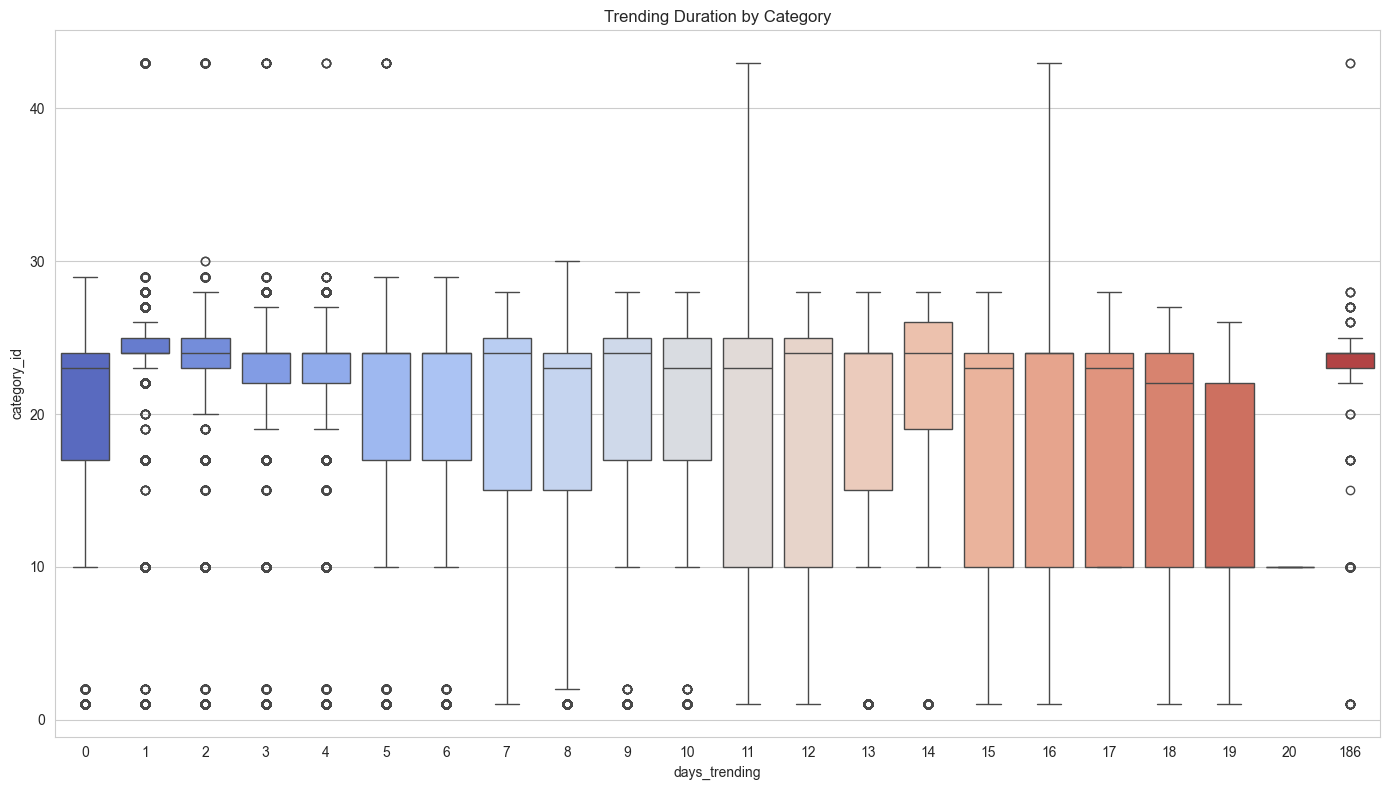

In [40]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))
category_duration = df_all.merge(duration_df, on='video_id')
sns.boxplot(data=category_duration, x='days_trending', y='category_id', palette='coolwarm')
plt.title("Trending Duration by Category")
plt.tight_layout()
plt.show()


In [42]:
export_df = df_all[['video_id', 'title', 'category_id', 'views', 'likes', 'dislikes', 'comment_count',
                    'region', 'publish_time', 'trending_date', 'title_sentiment', 'sentiment_label']]
export_df.to_csv('cleaned_youtube_trending.csv', index=False)
